In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
import seaborn as sns
%matplotlib inline
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

import cufflinks as cf
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona


# Loading Data

In [2]:
data=pd.read_csv("ncdc-covid19-states.csv")
data.head(2)

Unnamed: 0  OBJECTID   CODE    STATE     ADMIN_NAME    GEO_ZONE  \
0           0         1  NG001     Abia     Abia State  South East   
1           1         2  NG002  Adamawa  Adamawa State  North East   

      AREA_SQKM  POP_2016       LAT       LONG  CASES  DEATHS  RECOVERED  \
0   4858.882335   3644714  5.453302   7.523190    898       8        872   
1  37924.987860   4145684  9.323227  12.400241    257      19        238   

   ACTIVE  SCREENED  
0      18         0  
1       0         2

In [3]:
ft=data.copy()  # This is to enable us retain the original Dataset in case of any problem

In [4]:
ft.head(2)

Unnamed: 0  OBJECTID   CODE    STATE     ADMIN_NAME    GEO_ZONE  \
0           0         1  NG001     Abia     Abia State  South East   
1           1         2  NG002  Adamawa  Adamawa State  North East   

      AREA_SQKM  POP_2016       LAT       LONG  CASES  DEATHS  RECOVERED  \
0   4858.882335   3644714  5.453302   7.523190    898       8        872   
1  37924.987860   4145684  9.323227  12.400241    257      19        238   

   ACTIVE  SCREENED  
0      18         0  
1       0         2

In [5]:
ft.tail(1)

Unnamed: 0  OBJECTID   CODE    STATE     ADMIN_NAME    GEO_ZONE  \
36          36        37  NG037  Zamfara  Zamfara State  North West   

      AREA_SQKM  POP_2016        LAT      LONG  CASES  DEATHS  RECOVERED  \
36  33561.95914   4376911  12.101505  6.246535     79       5         73   

    ACTIVE  SCREENED  
36       1         0

In [6]:
ft.shape

(37, 15)

In [7]:
ft.size

555

# Sanity check of Data

In [8]:
ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  37 non-null     int64  
 1   OBJECTID    37 non-null     int64  
 2   CODE        37 non-null     object 
 3   STATE       37 non-null     object 
 4   ADMIN_NAME  37 non-null     object 
 5   GEO_ZONE    37 non-null     object 
 6   AREA_SQKM   37 non-null     float64
 7   POP_2016    37 non-null     int64  
 8   LAT         37 non-null     float64
 9   LONG        37 non-null     float64
 10  CASES       37 non-null     int64  
 11  DEATHS      37 non-null     int64  
 12  RECOVERED   37 non-null     int64  
 13  ACTIVE      37 non-null     int64  
 14  SCREENED    37 non-null     int64  
dtypes: float64(3), int64(8), object(4)
memory usage: 4.5+ KB


### Insight:
- There are 37 records in the dataset and 15 columns
- The data is mostly typed correct.
- The DataFrame uses around 4.5+ KB of memory, which seems manageable.

In [9]:
ft.isnull().sum()

Unnamed: 0    0
OBJECTID      0
CODE          0
STATE         0
ADMIN_NAME    0
GEO_ZONE      0
AREA_SQKM     0
POP_2016      0
LAT           0
LONG          0
CASES         0
DEATHS        0
RECOVERED     0
ACTIVE        0
SCREENED      0
dtype: int64

In [10]:
ft.duplicated().sum()

0

#### Insight:
- No missing value 
- No duplicate.

## Exploratory Data Analysis

In [11]:
ft.select_dtypes(include="object").describe().T

count unique            top freq
CODE          37     37          NG001    1
STATE         37     37           Abia    1
ADMIN_NAME    37     37     Abia State    1
GEO_ZONE      37      6  North Central    7

#### Insight:
- Summary statistics for the categorical columns.
- The **count** shows number of non-missing value. In order word, there is no missing value.
- The **unique** shows the number of distinct values in each categorical column. Of course there 6 geopolitical zones in Nigeria.
- The **top** shows the  most frequent value in each categorical column. The North Central is the most occurance in GEO_ZONE and it appeared 7 time(**freq**)

In [12]:
ft.describe()

Unnamed: 0   OBJECTID     AREA_SQKM      POP_2016        LAT  \
count   37.000000  37.000000     37.000000  3.700000e+01  37.000000   
mean    18.000000  19.000000  24652.792986  5.075224e+06   8.477059   
std     10.824355  10.824355  18344.693753  2.292310e+06   2.521534   
min      0.000000   1.000000   3701.447550  2.228965e+06   4.766315   
25%      9.000000  10.000000   8644.298164  3.644714e+06   6.522424   
50%     18.000000  19.000000  21417.610880  4.541779e+06   8.023131   
75%     27.000000  28.000000  33561.959140  5.568946e+06  10.392367   
max     36.000000  37.000000  75949.947450  1.270678e+07  13.037993   

            LONG         CASES      DEATHS     RECOVERED      ACTIVE  \
count  37.000000     37.000000   37.000000     37.000000   37.000000   
mean    7.368314   1694.351351   30.918919   1579.189189   84.243243   
std     2.452557   3538.204105   38.314762   3365.141303  195.857999   
min     3.473262      5.000000    2.000000      3.000000    0.000000   
25%     5.590435    277.000000   11.000000    259.000000    4.000000   
50%     7.195557    745.000000   20.000000    705.000000   10.000000   
75%     8.598756   1747.000000   36.000000   1684.000000   44.000000   
max    13.098771  21212.000000  215.000000  20296.000000  822.000000   

         SCREENED  
count   37.000000  
mean     9.000000  
std     25.179357  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      5.000000  
max    122.000000

#### Insight:
- Summary statistics for the numerical columns which provide descriptive statistics.

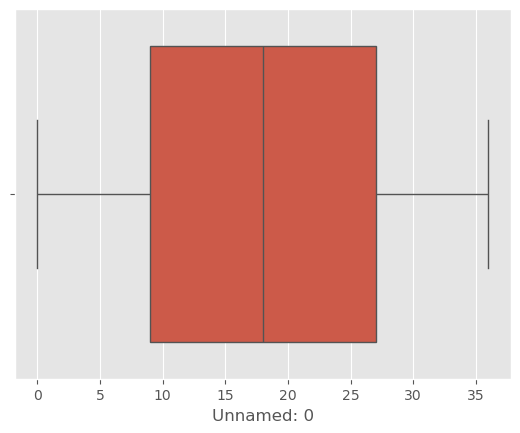

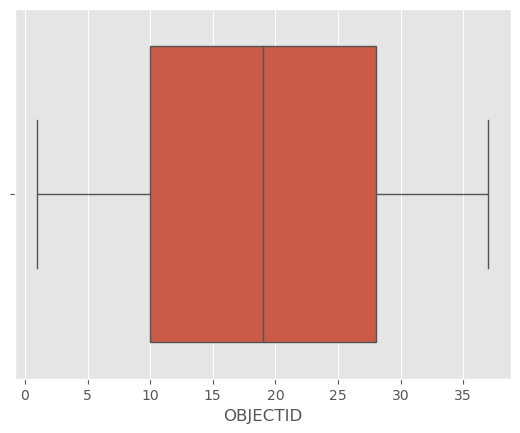

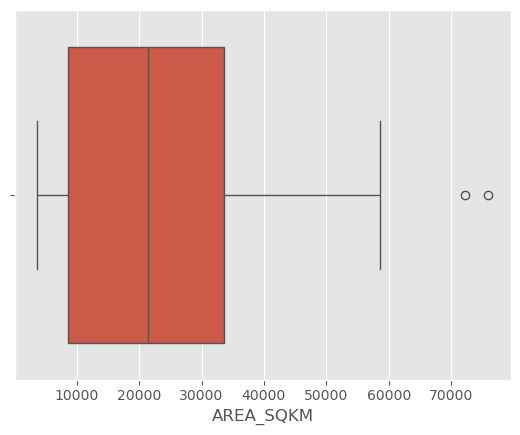

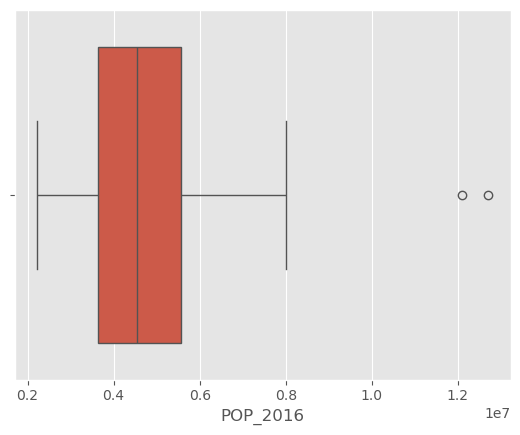

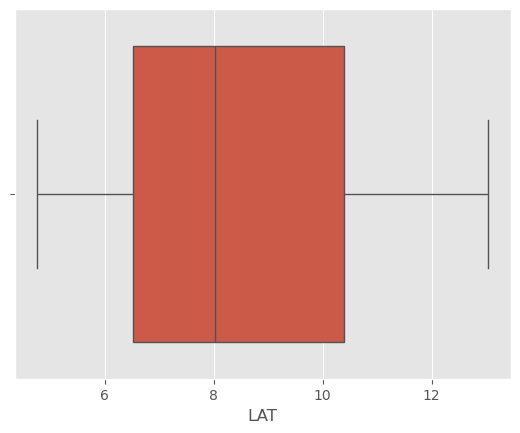

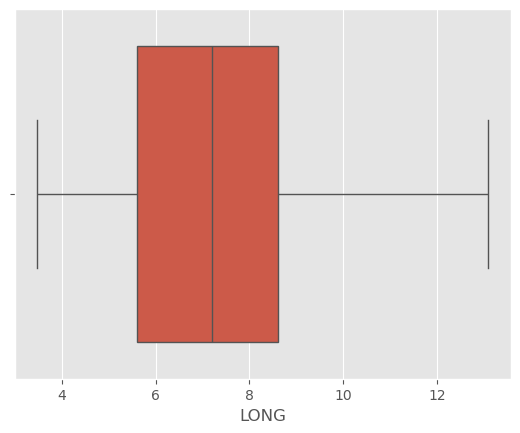

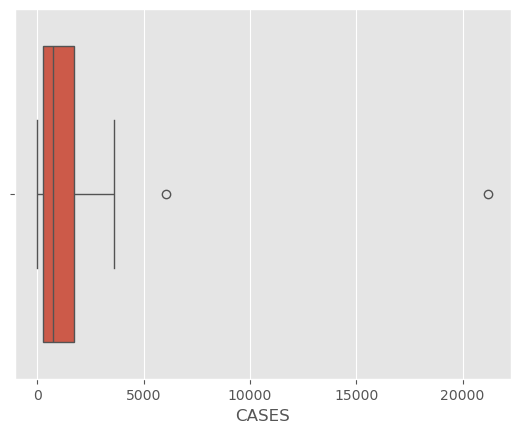

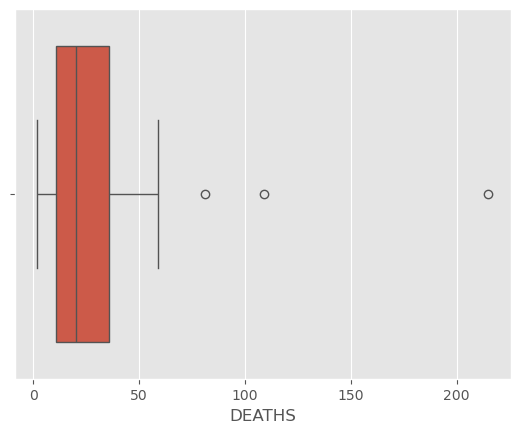

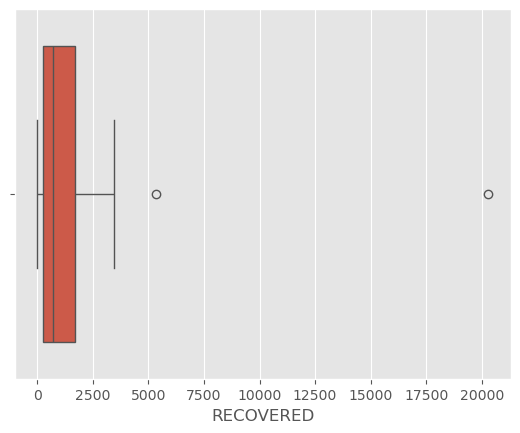

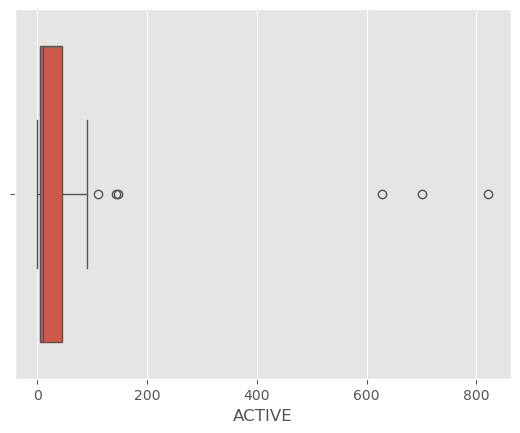

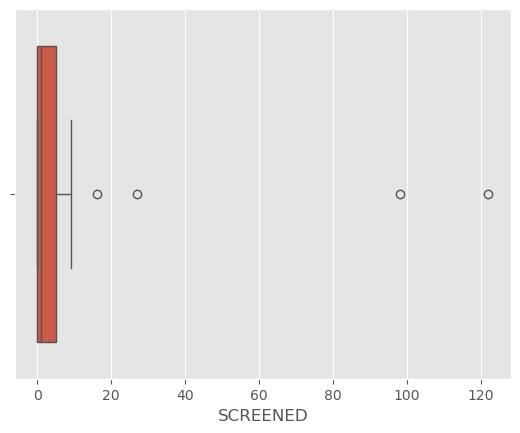

In [13]:
for column in ft.select_dtypes(include="number").columns:
    sns.boxplot(ft,x=column)
    plt.show()
                

#### Insight:
- Identification of Outliers in the following columns *Screen*, *Active*, *Recoverd*, *Deaths*, *Pop_2016* and *Cases*

<Axes: >

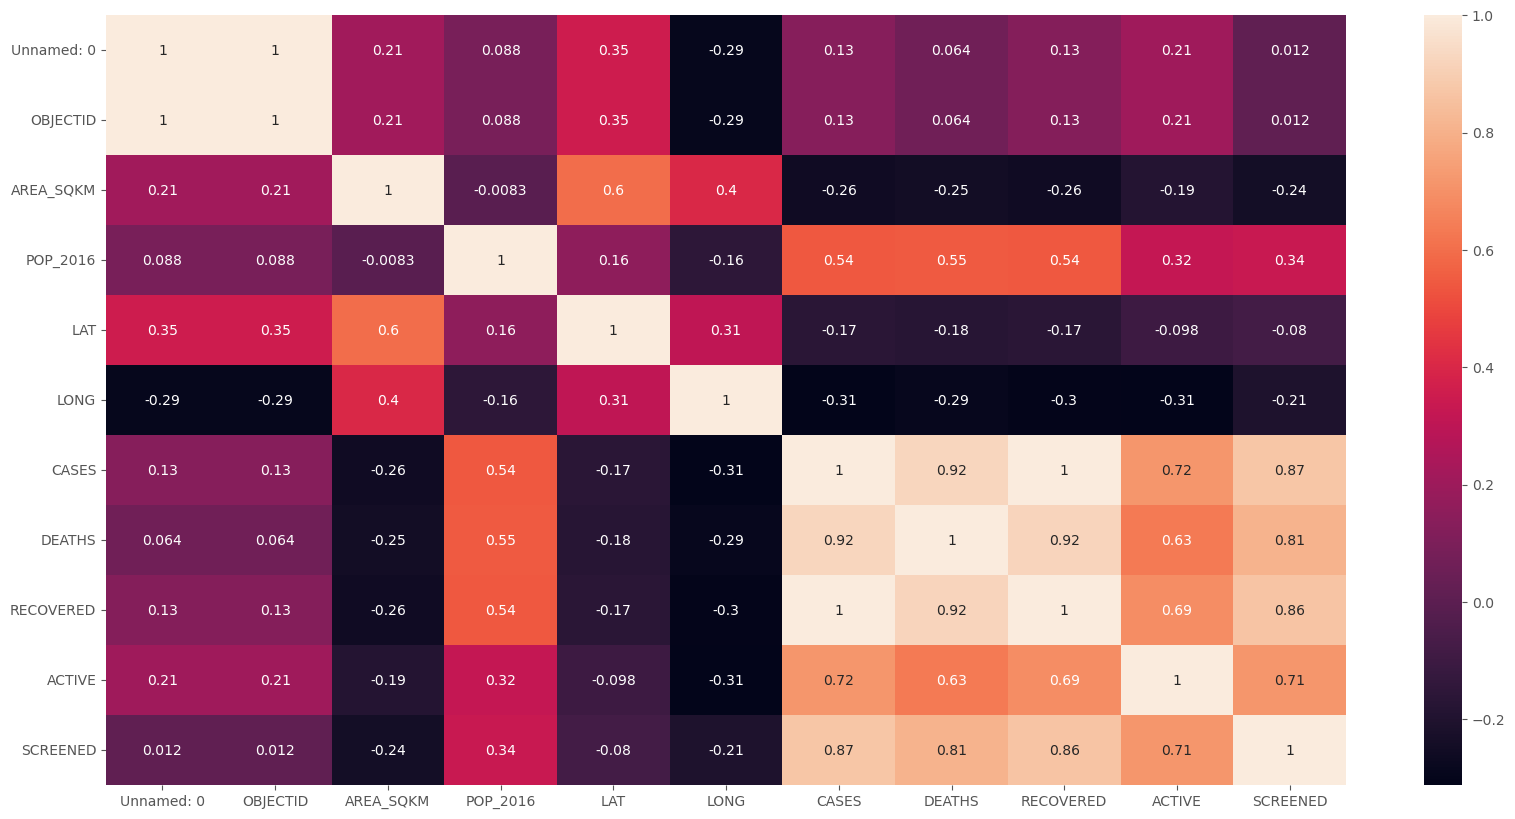

In [14]:
correlation=ft.select_dtypes(include="number").corr()
plt.figure(figsize=(20,10))
sns.heatmap(correlation,annot=True)

#### Insigt:
- There are positive correlation among *Case*, *Deaths*, *Recoverd*, *Active*, and *Screeened*
- This means that when the number of cases increases, the number of deaths and recoered increases 

In [15]:
def whisker(column):
    Q1=ft[column].quantile(0.25)
    Q3= ft[column].quantile(0.75)
    IQR=Q3-Q1
    lb=Q1-1.5*IQR
    ub=Q3+1.5*IQR
    ft[column]=np.where(ft[column]<lb, lb,ft[column])
    ft[column]=np.where(ft[column]>ub, ub,ft[column])
    return ft

for column in ft.select_dtypes(include="number").columns:
    whisker(column)

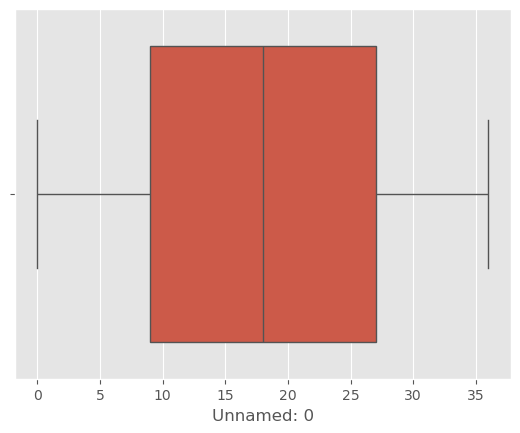

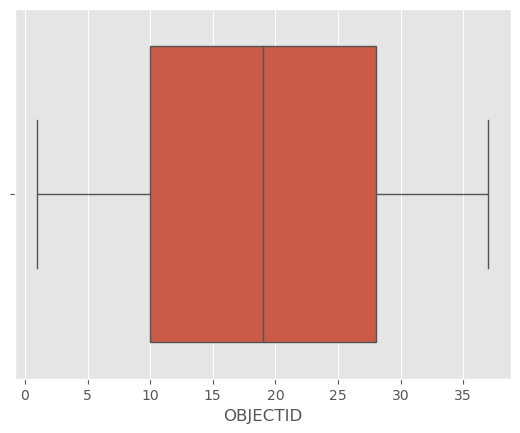

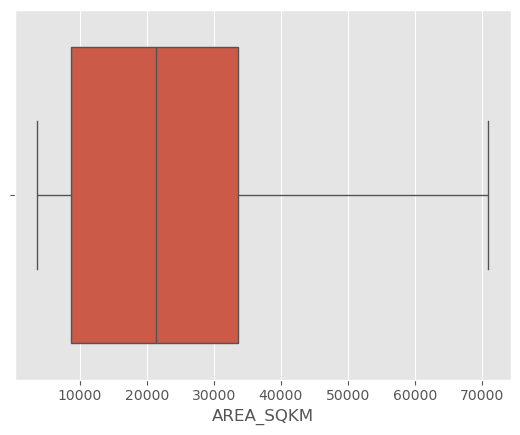

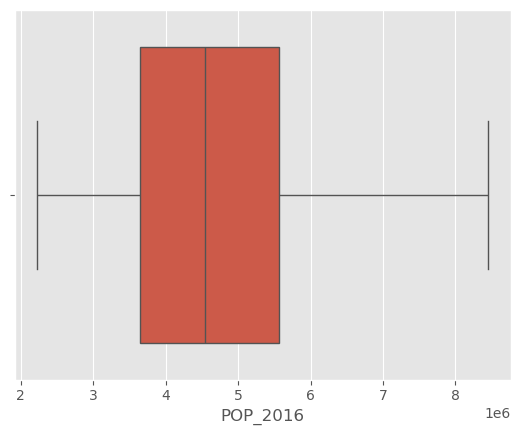

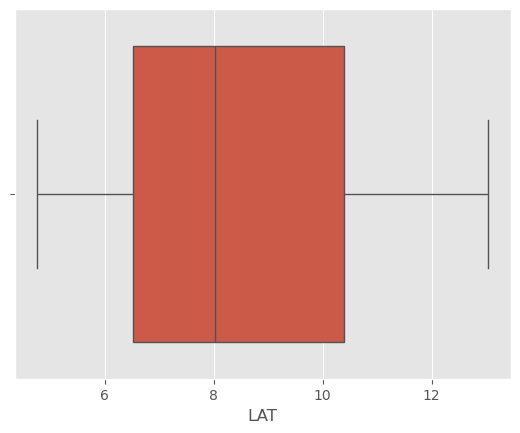

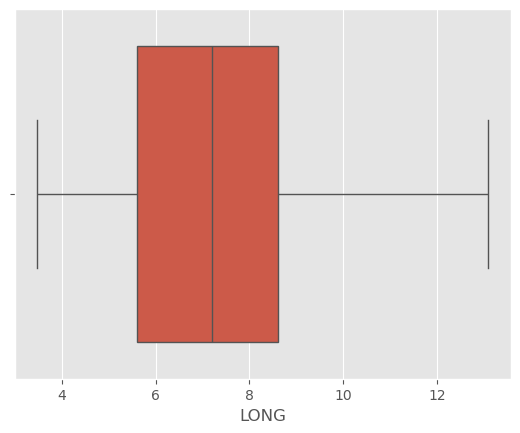

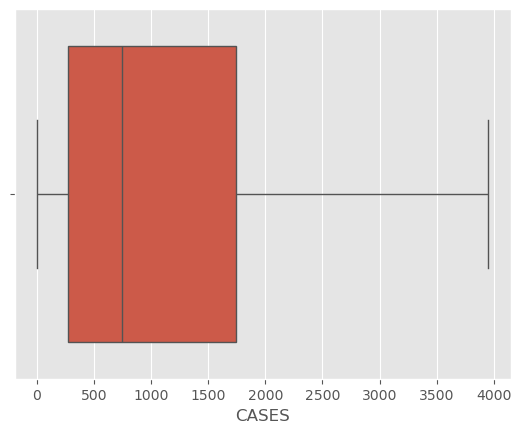

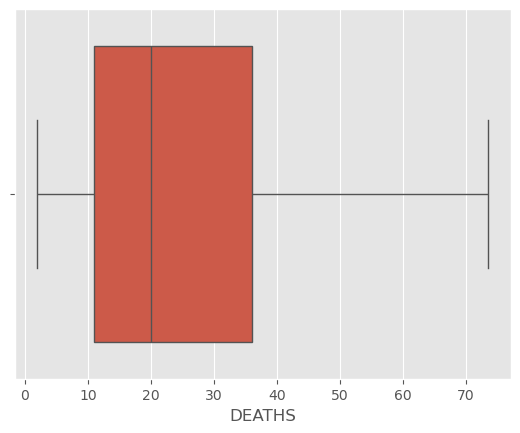

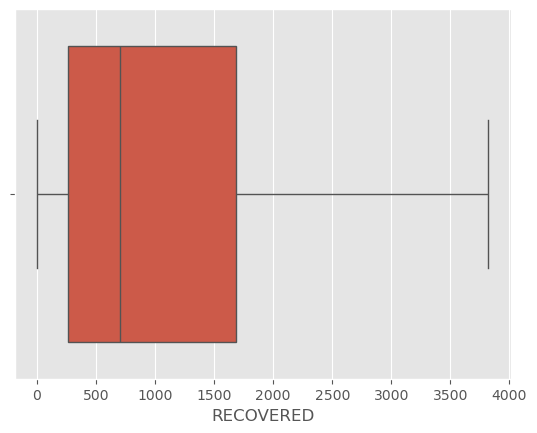

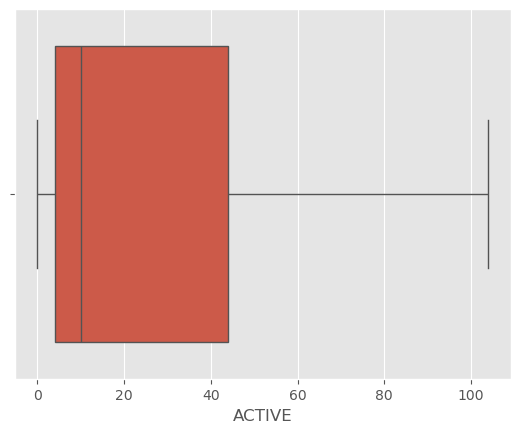

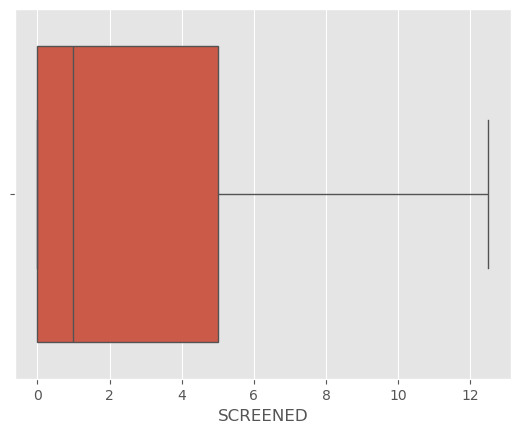

In [16]:
for column in ft.select_dtypes(include="number").columns:
    sns.boxplot(ft,x=column)
    plt.show()

#### - Outliers Treated 

In [17]:
ft.head(2)

Unnamed: 0  OBJECTID   CODE    STATE     ADMIN_NAME    GEO_ZONE  \
0         0.0       1.0  NG001     Abia     Abia State  South East   
1         1.0       2.0  NG002  Adamawa  Adamawa State  North East   

      AREA_SQKM   POP_2016       LAT       LONG  CASES  DEATHS  RECOVERED  \
0   4858.882335  3644714.0  5.453302   7.523190  898.0     8.0      872.0   
1  37924.987860  4145684.0  9.323227  12.400241  257.0    19.0      238.0   

   ACTIVE  SCREENED  
0    18.0       0.0  
1     0.0       2.0

In [18]:
ft.drop(columns=["Unnamed: 0","OBJECTID","CODE"], inplace=True)

- Dropping the unnecessary columns

In [19]:
ft.head(2)

STATE     ADMIN_NAME    GEO_ZONE     AREA_SQKM   POP_2016       LAT  \
0     Abia     Abia State  South East   4858.882335  3644714.0  5.453302   
1  Adamawa  Adamawa State  North East  37924.987860  4145684.0  9.323227   

        LONG  CASES  DEATHS  RECOVERED  ACTIVE  SCREENED  
0   7.523190  898.0     8.0      872.0    18.0       0.0  
1  12.400241  257.0    19.0      238.0     0.0       2.0

In [20]:
ft.groupby("STATE")["AREA_SQKM"].sum().reset_index().sort_values(by="AREA_SQKM",ascending=False)

STATE     AREA_SQKM
26        Niger  70938.450604
7         Borno  70938.450604
34       Taraba  58561.232360
4        Bauchi  48496.400510
18       Kaduna  44146.822700
35         Yobe  41414.373580
1       Adamawa  37924.987860
21        Kebbi  36788.020920
23        Kwara  33838.416910
36      Zamfara  33561.959140
33       Sokoto  32257.590270
6         Benue  31462.228460
22         Kogi  28925.879040
30          Oyo  27824.833950
25     Nasarawa  26750.458860
31      Plateau  26489.782860
20      Katsina  23957.923590
17       Jigawa  23201.550360
8   Cross River  21417.610880
19         Kano  20310.402310
11          Edo  19555.551900
15        Gombe  17437.997260
9         Delta  17112.996170
27         Ogun  16810.673680
28         Ondo  15132.200910
32       Rivers  10188.803810
5       Bayelsa   9546.418182
29         Osun   8644.298164
13        Enugu   7635.724099
14          FCT   7388.142266
2     Akwa Ibom   6723.202769
10       Ebonyi   6336.481274
12        Ekiti   5773.235782
16          Imo   5075.461183
0          Abia   4858.882335
3       Anambra   4807.933352
24        Lagos   3701.447550

### Insight:
- Niger State has the largest land area in square kilometers, significantly larger than both the Federal Capital Territory (FCT) and Lagos State.

In [21]:
gz=ft.groupby(["GEO_ZONE", "STATE"])["AREA_SQKM"].sum().reset_index()
gz["GEO_ZONE_RC"]=gz.groupby("GEO_ZONE").cumcount() + 1
gz["GEO_ZONE_RS"]=gz.groupby("GEO_ZONE")["AREA_SQKM"].cumsum()



def highlight_last_cumsum(s):
    last_cumsum = s.groupby(gz['GEO_ZONE']).transform('last')
    return ['background-color: green' if v == l else '' for v, l in zip(s, last_cumsum)]


gz.style.apply(highlight_last_cumsum, subset=['GEO_ZONE_RS'])

In [22]:
zone_area=ft.groupby("GEO_ZONE")["AREA_SQKM"].sum().reset_index()
zone_area.style.background_gradient(cmap="Blues")

#### Insight:
- It is clear that the North Central and North West regions each have seven (7) states with total land areas of approximately 225K and 214K square kilometers respectively.
- The North East, South South, and South West regions each have six (6) states with total land areas of approximately 274K, 84K, and 77K square kilometers respectively.
- The South East is the only region with five (5) states having a total land area of about 28K square kilometers.
* Therefore, the North East has the largest land area followed by the North Central region. The South East has the smallest land area. This has economic and political implications.


In [23]:
zone=ft.groupby("GEO_ZONE")[["CASES","DEATHS", "RECOVERED","ACTIVE"]].sum().reset_index()
zone.style.background_gradient(cmap="Blues")

#### Insight:
- From the above, it can be observed that the six geopolitical zones in Nigeria have different numbers of cases, deaths, recoveries, and active cases of COVID-19. The South West has the highest number of cases and recoveries, followed by the North Central. The South South region has the highest number of deaths, followed by the South West, while the North Central has the highest number of active cases, followed by the South West.

In [24]:
state=ft.groupby("STATE")[["CASES","DEATHS", "RECOVERED","ACTIVE"]].sum().reset_index()
state.style.background_gradient(cmap="Blues")

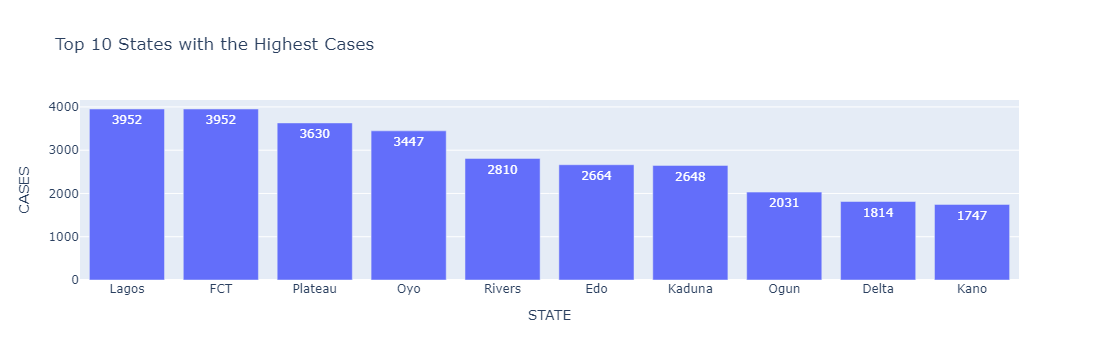

In [25]:
fig=px.bar(state.sort_values(by="CASES",ascending=False).head(10),x="STATE",y="CASES",title="Top 10 States with the Highest Cases",text_auto=True)
fig.show()

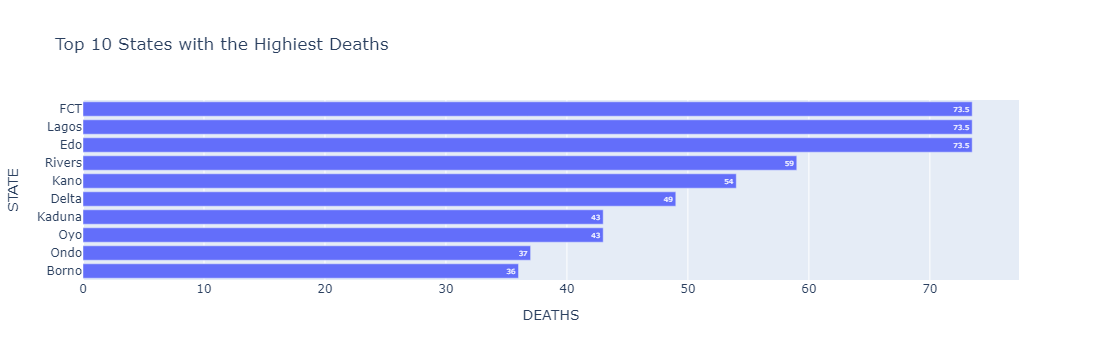

In [26]:
fig=px.bar(state.sort_values(by="DEATHS",ascending=False).head(10)[::-1],y="STATE",x="DEATHS",title="Top 10 States with the Highiest Deaths",text_auto=True)
fig.show()

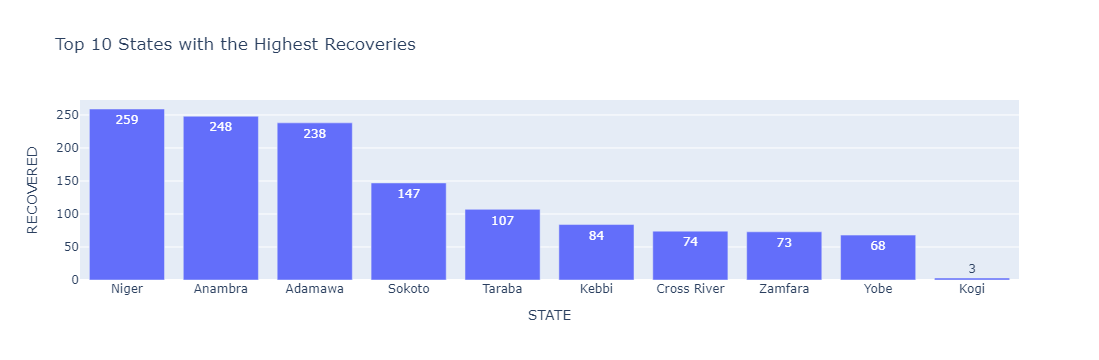

In [28]:
fig=px.bar(state.sort_values(by="RECOVERED",ascending=True).head(10)[::-1],x="STATE",y="RECOVERED",title="Top 10 States with the Highest Recoveries",text_auto=True)
fig.show()


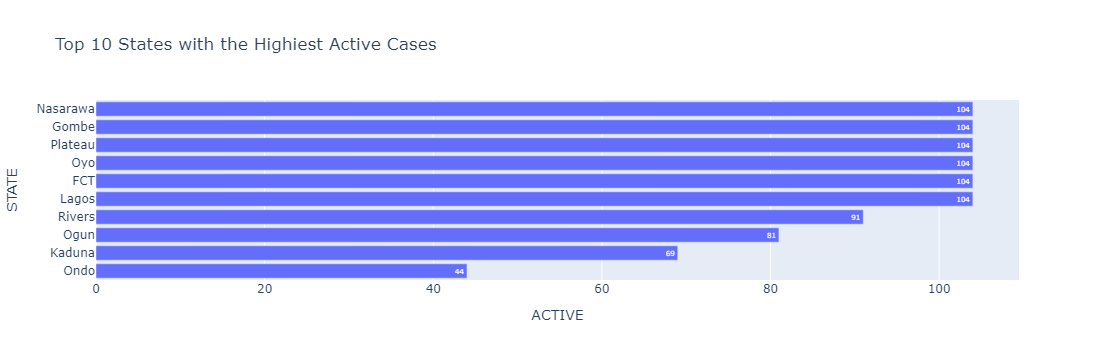

In [29]:
fig=px.bar(state.sort_values(by="ACTIVE",ascending=False).head(10)[::-1],y="STATE",x="ACTIVE",title="Top 10 States with the Highiest Active Cases",text_auto=True)
fig.show()

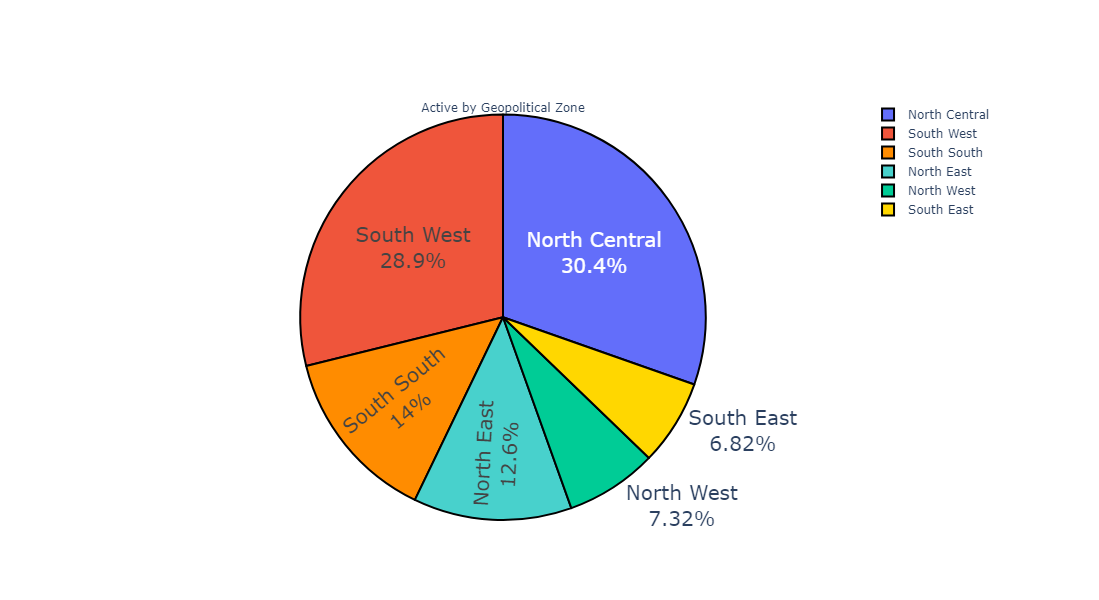

In [30]:
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=ft["GEO_ZONE"],title="Active by Geopolitical Zone",
                             values=ft['ACTIVE'])])
fig.update_traces(hoverinfo='label+percent', textinfo='label+percent',textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(width=800,
    height=600)
fig.show()

In [31]:
def plot_treemap_cases(dataframe,variable,value):
    fig = px.treemap(dataframe.sort_values(by=value,ascending=False).reset_index(drop=True),
                     path=[variable],values=value,title=("Highest Number of Cases by Geopolitical Zone"),
                     color_discrete_sequence = px.colors.qualitative.Set1)
    fig.data[0].textinfo = 'label+text+value'
    
    fig.show()
    
def plot_treemap_deaths(dataframe,variable,value):
    fig = px.treemap(dataframe.sort_values(by=value,ascending=False).reset_index(drop=True),
                     path=[variable],values=value,title=("Highest Number of Deaths by Geopolitical Zone"),
                     color_discrete_sequence = px.colors.qualitative.Set1)
    fig.data[0].textinfo = 'label+text+value'
    
    fig.show()

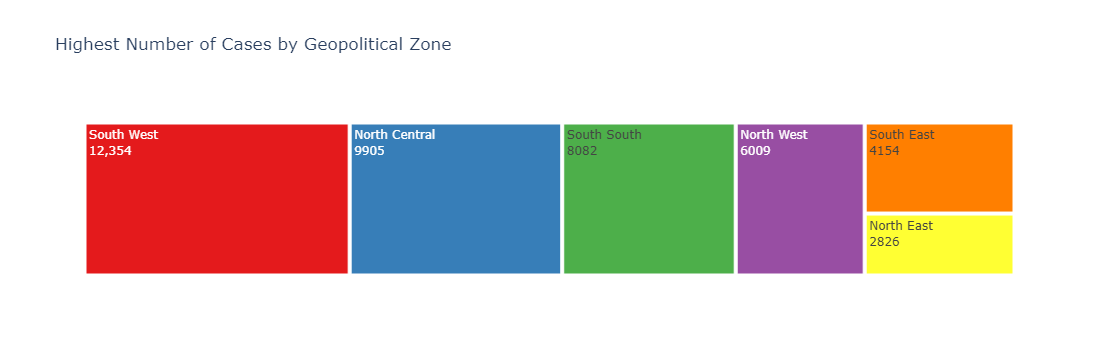

In [32]:
plot_treemap_cases(zone,"GEO_ZONE","CASES")

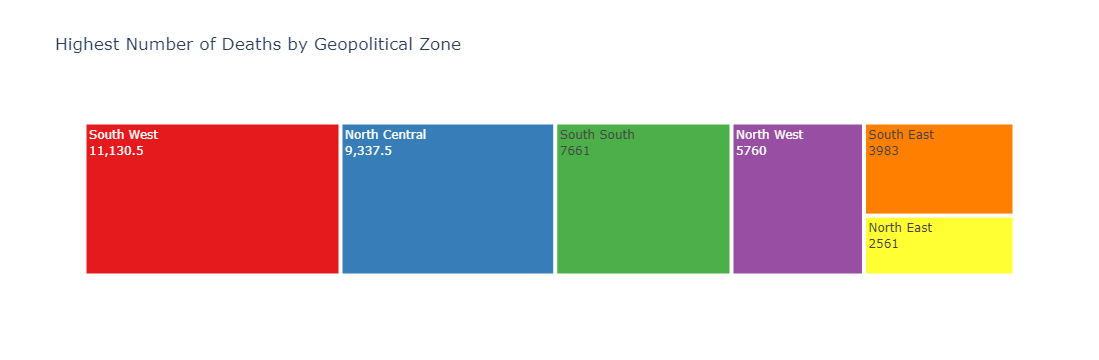

In [33]:
plot_treemap_deaths(zone,"GEO_ZONE","RECOVERED")

In [34]:
#convert to GeoDataFrame
#Method1
gdf1= gpd.GeoDataFrame(ft, geometry=gpd.points_from_xy(ft["LAT"],ft["LONG"]))

In [35]:
#method II
points=[Point(x,y) for x, y in zip(ft["LAT"],ft["LONG"])]
gdf2=gpd.GeoDataFrame(ft,geometry=points)

In [36]:
gdf1.head(2)

STATE     ADMIN_NAME    GEO_ZONE     AREA_SQKM   POP_2016       LAT  \
0     Abia     Abia State  South East   4858.882335  3644714.0  5.453302   
1  Adamawa  Adamawa State  North East  37924.987860  4145684.0  9.323227   

        LONG  CASES  DEATHS  RECOVERED  ACTIVE  SCREENED  \
0   7.523190  898.0     8.0      872.0    18.0       0.0   
1  12.400241  257.0    19.0      238.0     0.0       2.0   

                   geometry  
0    POINT (5.4533 7.52319)  
1  POINT (9.32323 12.40024)

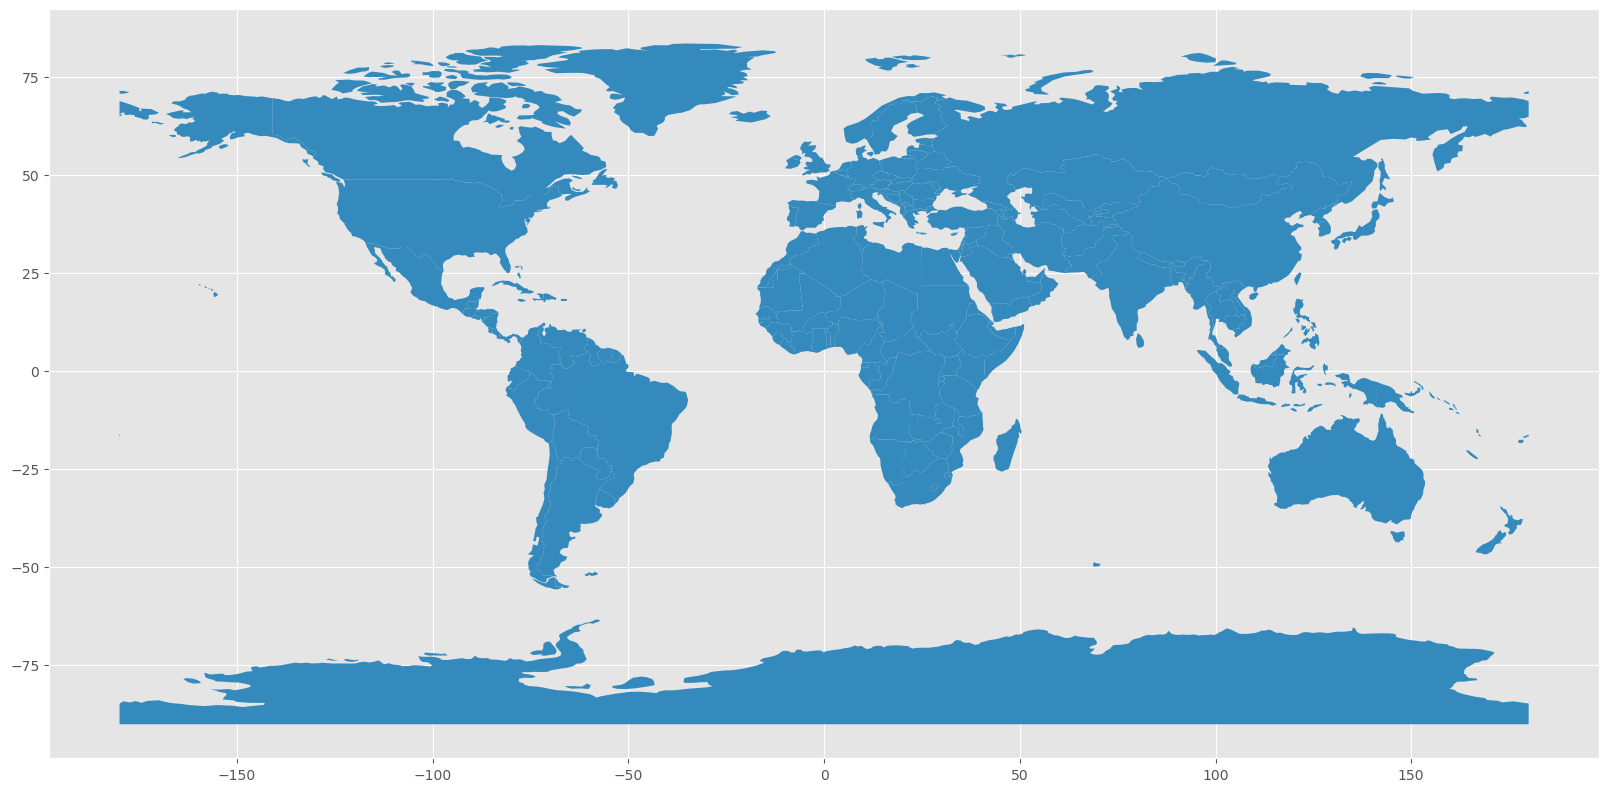

In [37]:
#Overlap with World Map
world= gpd.read_file(r'C:\Users\USER\Desktop\DATAANALYST\110m_cultural\ne_110m_admin_0_countries.shp')
ax=world.plot(figsize=(20,10))
#ax.axis("off")


In [38]:
ft.head(1)

STATE  ADMIN_NAME    GEO_ZONE    AREA_SQKM   POP_2016       LAT     LONG  \
0  Abia  Abia State  South East  4858.882335  3644714.0  5.453302  7.52319   

   CASES  DEATHS  RECOVERED  ACTIVE  SCREENED  
0  898.0     8.0      872.0    18.0       0.0

In [39]:
gpdf_ft=gpd.GeoDataFrame(ft,geometry=[Point(x,y) for x, y in zip(ft["LAT"],ft["LONG"])])

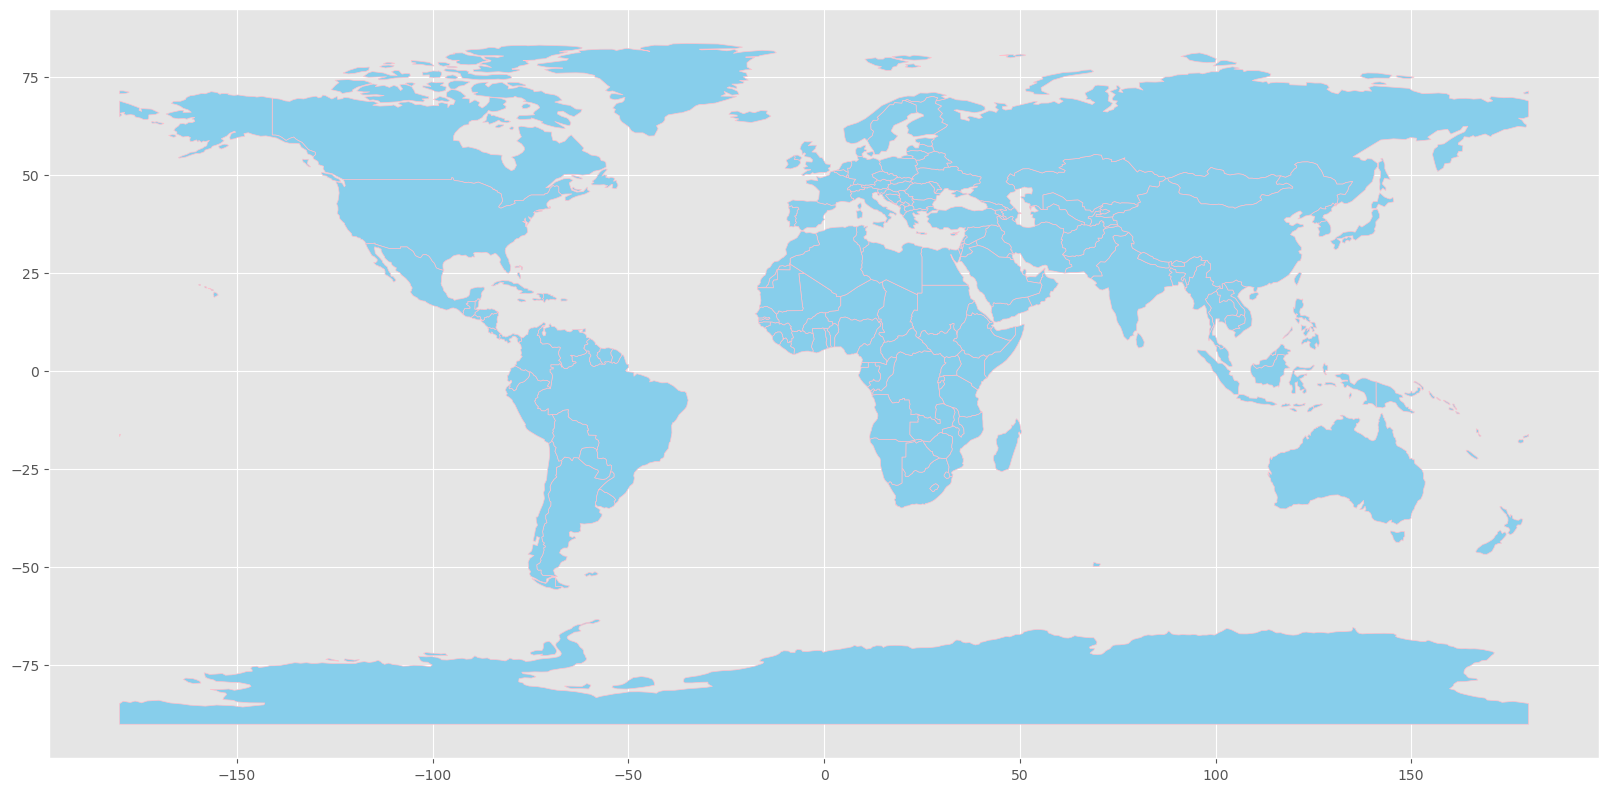

In [40]:
world_map=gpd.read_file(r'C:\Users\USER\Desktop\DATAANALYST\110m_cultural\ne_110m_admin_0_countries.shp')
ax=world_map.plot(figsize=(20,10), color="skyblue",edgecolor="Pink")

<Axes: >

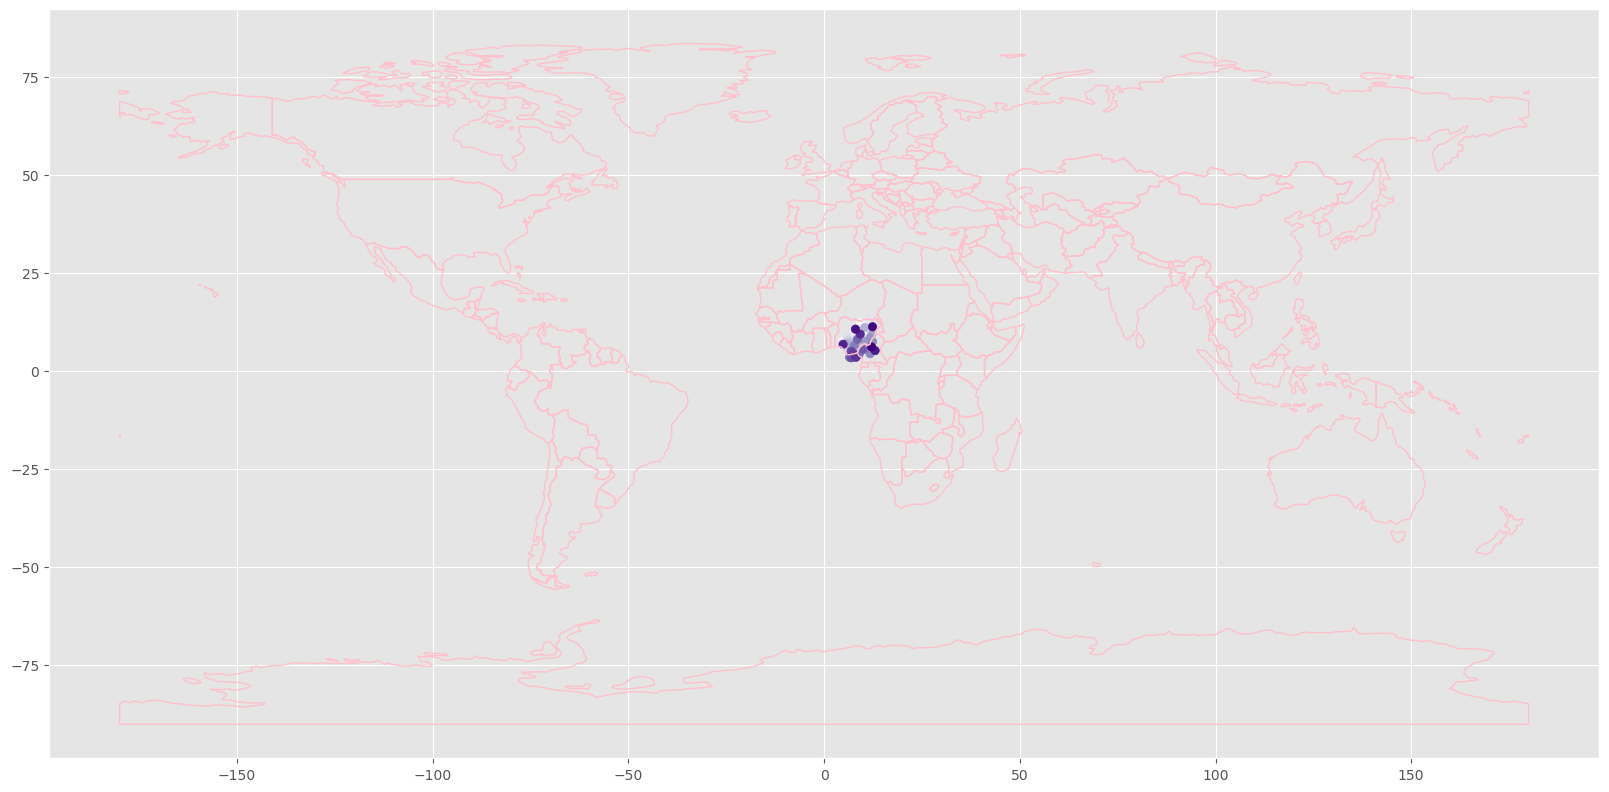

In [41]:
fig, ax= plt.subplots(figsize=(20,10))
gpdf_ft.plot(cmap="Purples",ax=ax)
world.geometry.boundary.plot(color="Pink",edgecolor="green", linewidth=1, ax=ax)

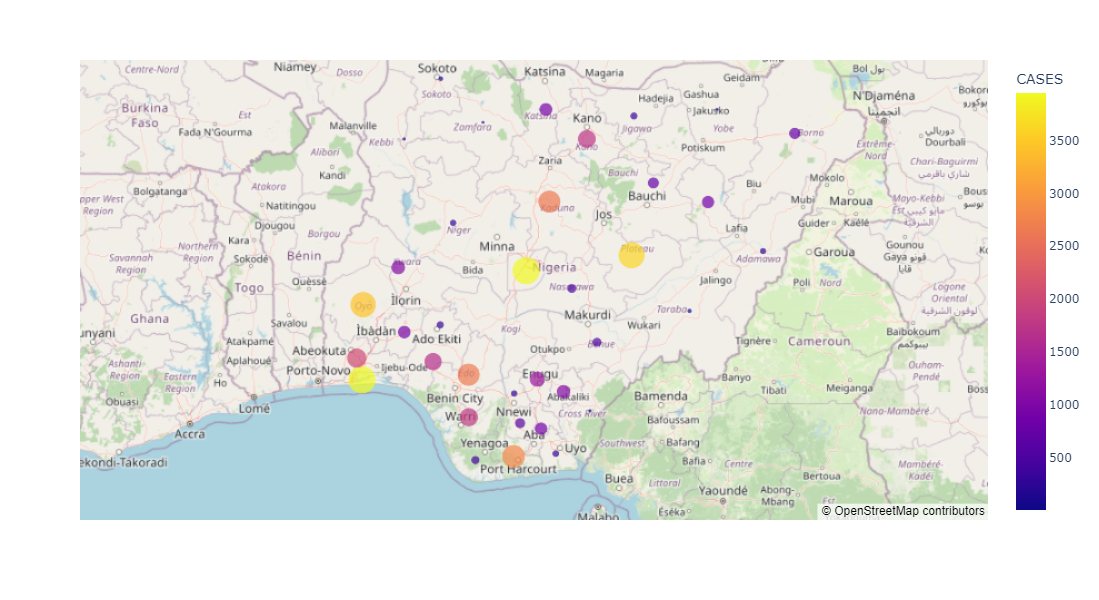

In [42]:
# Create a scatter mapbox plot
fig = px.scatter_mapbox(ft, lat='LAT', lon='LONG', hover_name='STATE',
                        hover_data=['CASES','DEATHS','RECOVERED','ACTIVE','SCREENED'], color='CASES', size='CASES', 
                        zoom=5, height=600)

# Update the layout to use a Mapbox style
fig.update_layout(mapbox_style='open-street-map')